# Ruble Volatility Project — Part 3: Time Series ARIMA Modeling

This notebook ([03_Time_Series_ARIMA_Modeling.ipynb.ipynb](03_Time_Series_ARIMA_Modeling.ipynb.ipynb)) continues the Ruble Volatility Project by building predictive models for the RUB/USD exchange rate using macroeconomic indicators.

In this notebook (03_Time_Series_ARIMA_Modeling.ipynb), I will:
1. Fit baseline ARIMA models to capture autoregressive and moving average dynamics in the ruble series
2. Extend to SARIMAX models by incorporating exogenous macroeconomic variables (Brent oil price, GDP per capita)
3. Evaluate multiple SARIMAX specifications and select the best-performing one based on AIC/BIC and out-of-sample RMSE
4. Forecast the ruble exchange rate for 2024 using finalized macroeconomic values
5. Implement rolling and expanding window forecasts to assess temporal robustness
6. Log-transform the ruble series to stabilize variance and compare predictive performance

This notebook lays the foundation for benchmark forecasting and sets the stage for future modeling using nonlinear and volatility-focused methods (e.g., GARCH, XGBoost, LSTM) in the next phase of the project in ([04_Time_Series_GARCH_Modeling.ipynb](04_Time_Series_GARCH_Modeling.ipynb)).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore")
from stargazer.stargazer import Stargazer

### I. Loading data

In [76]:
data1 = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction/data/Full_Ruble_Monthly_Data.csv")
data1.columns

Index(['date', 'old_RUB', 'year', 'month', 'GDP_per_capita', 'Brent_price',
       'GDP_deflator', 'FD_investment', 'Inflation', 'currency_rate_change',
       'sov_disrupt', 'denomination', 'RUB'],
      dtype='object')

In [77]:
data1

,date,old_RUB,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,currency_rate_change,sov_disrupt,denomination,RUB
0,1992-07-31,141.556000,1992.0,7.0,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,2.928888,1.0,pre,0.141556
1,1992-08-31,168.162500,1992.0,8.0,3098.802734,19.65,1490.418425,1.161000e+09,1490.418425,3.274988,1.0,pre,0.168162
2,1992-09-30,220.488889,1992.0,9.0,3098.802734,20.18,1490.418425,1.161000e+09,1490.418425,2.546404,1.0,pre,0.220489
3,1992-10-31,353.777778,1992.0,10.0,3098.802734,19.13,1490.418425,1.161000e+09,1490.418425,5.348118,1.0,pre,0.353778
4,1992-11-30,426.250000,1992.0,11.0,3098.802734,19.25,1490.418425,1.161000e+09,1490.418425,1.491099,1.0,pre,0.426250
...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,2025-04-30,83.243645,2025.0,4.0,14260.000000,63.37,8.200000,3.300000e+09,8.140000,-0.213785,0.0,post,83.243645
394,2025-05-31,80.237650,2025.0,5.0,14260.000000,64.32,8.200000,3.300000e+09,8.140000,-0.178412,0.0,post,80.237650
395,2025-06-30,78.677635,2025.0,6.0,14260.000000,68.15,8.200000,3.300000e+09,8.140000,-0.004909,0.0,post,78.677635
396,2025-07-31,78.850139,2025.0,7.0,14260.000000,73.43,8.200000,3.300000e+09,8.140000,0.101659,0.0,post,78.850139


In [79]:
data = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction/data/'Full_Ruble_Monthly_Data_Ready.csv")
data.shape

(398, 14)

### II. ARIMA

In [80]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
rub_series = np.log(data['RUB'].dropna())

#### 1. Base ARIMA (1,1,1) without train/test and CV - ARIMA Test

To establish a benchmark for forecasting RUB/USD, I fit a base ARIMA(1,1,1) model. The model includes:

- AR(1): One lag of the autoregressive term to capture short-term memory
- I(1): First-order differencing to address non-stationarity (as confirmed by the ADF test)
- MA(1): One lag of the moving average term to smooth out shocks

In [81]:
model1 = ARIMA(rub_series, order=(1, 1, 1)) 
model1_fit = model1.fit()

print(model1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  398
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 533.805
Date:                Sun, 05 Oct 2025   AIC                          -1061.611
Time:                        17:59:15   BIC                          -1049.659
Sample:                    07-31-1992   HQIC                         -1056.876
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5749      0.059      9.722      0.000       0.459       0.691
ma.L1         -0.1624      0.066     -2.474      0.013      -0.291      -0.034
sigma2         0.0040   5.58e-05     71.188      0.0

The model fits the historical data closely, effectively replicating past patterns. 

However, most coefficients are statistically insignificant, and there is clear heteroskedasticity (as indicated by the significant LB and JB tests), suggesting the need for a more complex model. This simple ARIMA does not yet incorporate macroeconomic drivers or structural shifts identified in EDA.

#### 2. ARIMA (2,1,1) 

In my earlier PACF plot (02 NOTEBOOK), we saw two significant spikes at lags 1 and 2, which supports using AR(2). We also saw that after differencing, the series became stationary and short-term autocorrelations mostly died off.

So moving from ARIMA(1,1,1) → ARIMA(2,1,1) is a data-driven next step.

In [82]:
model2 = ARIMA(rub_series, order=(2, 1, 1))
model2_fit = model2.fit()
print(model2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  398
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 534.738
Date:                Sun, 05 Oct 2025   AIC                          -1061.476
Time:                        17:59:15   BIC                          -1045.541
Sample:                    07-31-1992   HQIC                         -1055.164
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5272      0.050    -10.612      0.000      -0.625      -0.430
ar.L2          0.4236      0.041     10.303      0.000       0.343       0.504
ma.L1          0.9860      0.048     20.586      0.0

AIC dropped from 1924.26 to 1919.49, BIC dropped from 1936.20 to 1935.41, coefficients became statistically significant, and residual diagnostics improved. Next step is to use Auto ARIMA to confirm that (2,1,1) is optimal or identify a better configuration automatically.

#### 3. Auto ARIMA

In [83]:
auto_model = auto_arima(
    rub_series,
    seasonal=False, 
    stepwise=True,
    max_p=5, max_q=5,
    d=1,  # based on ADF test
    trace=True
)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1079.483, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-996.929, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1069.768, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1063.475, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-977.991, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1081.998, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1064.924, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1067.770, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1079.722, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1066.354, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1068.200, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1077.959, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1082.989, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1055.845, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[

The best model suggested was ARIMA(2,1,2), confirming the appropriateness of using two autoregressive terms (AR=2) while slightly improving the model by increasing the moving average component (MA=2). 

This reinforces the idea that the time series benefits from a richer structure in the short-memory component, and provides further confidence in the chosen configuration.

#### Comparison

In [84]:
auto_order = auto_model.order
model3_fit = ARIMA(rub_series, order=auto_order).fit()

stargazer = Stargazer([model1_fit, model2_fit, model3_fit])
stargazer.title("ARIMA Model Comparison")
model_labels = ['ARIMA(1,1,1)', 'ARIMA(2,1,1)', f'Auto ARIMA{auto_order}']
stargazer.custom_columns(model_labels, [1, 1, 1])
stargazer.show_model_numbers(False)

covariates = []
for name in ['ar.L1', 'ar.L2', 'ma.L1', 'const']:
    if any(name in m.params.index for m in [model1_fit, model2_fit, model3_fit]):
        covariates.append(name)
if covariates:
    stargazer.covariate_order(covariates)

print("AICs:")
for label, model in zip(model_labels, [model1_fit, model2_fit, model3_fit]):
    print(f"  {label}: {model.aic:.2f}")
print("BICs:")
for label, model in zip(model_labels, [model1_fit, model2_fit, model3_fit]):
    print(f"  {label}: {model.bic:.2f}")

from IPython.display import display, HTML
display(HTML(stargazer.render_html()))

AICs:
  ARIMA(1,1,1): -1061.61
  ARIMA(2,1,1): -1061.48
  Auto ARIMA(1, 1, 2): -1082.99
BICs:
  ARIMA(1,1,1): -1049.66
  ARIMA(2,1,1): -1045.54
  Auto ARIMA(1, 1, 2): -1067.05


To evaluate the optimal configuration for modeling RUB/USD, I compared three ARIMA models: a baseline ARIMA(1,1,1), a manual ARIMA(2,1,1), and an auto-selected ARIMA(2,1,2). The results show that ARIMA(2,1,2) outperforms the others in terms of both AIC and BIC, suggesting the best fit. 

Additionally, while the baseline ARIMA(1,1,1) model has no statistically significant coefficients, the higher-order models display strong significance across all terms (p < 0.01), confirming their relevance. This supports the findings from my EDA, where PACF plots suggested an AR(2) structure. 

Going forward, ARIMA(2,1,2) will serve as the foundation for forecasting and will later be extended into ARIMAX by incorporating macroeconomic variables.

### III. SARIMAX

Throughout this notebook, I use the SARIMAX model from the statsmodels library to run ARIMAX-style forecasts. Even though I’m not modeling seasonality here, SARIMAX is still the right tool because it allows me to include exogenous variables—like oil prices and lagged GDP—alongside the ARIMA structure. It’s flexible, reliable, and well-suited for time series forecasting with additional predictors.

1. Auto SARIMAX (with all macro variables)

ARIMA + eXogenous variables (external regressors).

After identifying ARIMA(2,1,2) as the optimal configuration, I extend the model by incorporating relevant macroeconomic indicators — Brent_price, GDP_per_capita, and Inflation to capture external shocks and improve forecasting performance. This approach allows us to test whether macro factors significantly drive RUB/USD fluctuations.

A quick check using auto_arima() with exogenous variables confirmed that the (2,1,2) specification remains optimal in the presence of macro predictors. 

In [85]:
auto_model2 = auto_arima(
    rub_series,
    exogenous=data[["GDP_per_capita", "FD_investment", "Inflation", "Brent_price", "GDP_deflator"]],
    seasonal=False,
    stepwise=True,
    max_p=5, max_q=5,
    d=1,
    trace=True
)
print(auto_model2.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1079.483, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-996.929, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1069.768, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1063.475, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-977.991, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1081.998, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1064.924, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1067.770, Time=0.61 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1079.722, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1066.354, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1068.200, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1077.959, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1082.989, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1055.845, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[

Auto ARIMA confirmed ARIMA(2,1,2) as the best model even with macro variables included, reinforcing earlier results. Key coefficients are significant, residuals show no strong autocorrelation, and the model is well-suited for forecasting despite some non-normality and heteroskedasticity.

Next step is to determine which macroeconomic variables should be included in the ARIMAX model. Should I include all macro variables? The answer is no. While adding multiple macro indicators can enrich the model, some are highly correlated and economically redundant. Inflation and GDP deflator both measure price changes; FDI and GDP per capita often rise together. Including all these variables produced unstable coefficients and convergence issues.

2. SARIMAX (with limited macro varables - check)

As a next step, I will include Brent_price, GDP_per_capita, and Inflation in the model — with Inflation serving as an example of a potentially redundant variable. 

In [86]:
exog_vars = data[['Brent_price', 'GDP_per_capita', 'Inflation']] 

# same ARIMA best order (2,1,2))
model_redundant = SARIMAX(rub_series, order=(2,1,2), exog=exog_vars)
model_redundant_fit = model_redundant.fit(disp=False)

print(model_redundant_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  398
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 487.633
Date:                Sun, 05 Oct 2025   AIC                           -959.265
Time:                        17:59:20   BIC                           -927.394
Sample:                    07-31-1992   HQIC                          -946.640
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Brent_price       -0.0015      0.001     -2.853      0.004      -0.003      -0.000
GDP_per_capita -1.355e-05   5.15e-06     -2.628      0.009   -2.36e-05   -3.44e-06
Inflation         -0.0003      0.000

* Brent_price and GDP_per_capita are significant (p < 0.05).
* Inflation is not significant (as excpected) - will be excluded from ARIMA.

Despite a convergence warning, key parameters are interpretable and stable.

From both a statistical and economic perspective, a smaller, theoretically justified set — such as Brent_price (commodity driver) and GDP_per_capita (broad economic health) — gives a more stable, interpretable SARIMAX model. 

This suggests exogenous macro variables can enhance RUB/USD forecasts.

3. SARIMAX (with Brent Price and GDP)

In [87]:
exog_vars = data[['Brent_price', 'GDP_per_capita']] 

# same ARIMA best order (2,1,2))
model_4 = SARIMAX(rub_series, order=(2,1,2), exog=exog_vars)
model4_fit = model_4.fit(disp=False)

print(model4_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  398
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 544.344
Date:                Sun, 05 Oct 2025   AIC                          -1074.689
Time:                        17:59:20   BIC                          -1046.801
Sample:                    07-31-1992   HQIC                         -1063.642
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Brent_price       -0.0011      0.001     -1.604      0.109      -0.002       0.000
GDP_per_capita -1.353e-05   7.42e-06     -1.824      0.068   -2.81e-05    1.01e-06
ar.L1              0.7806      0.206

4. SARIMAX with marco lags

To better align the model with economic reality, I introduce lags on key macro variables. Brent oil prices are lagged by one month to capture delayed effects on the RUB exchange rate, reflecting contract and market adjustment times. GDP per capita is lagged by 12 months to represent its slower publication cycle and structural impact rather than immediate monthly changes. This lag structure reduces simultaneity bias and produces a more theoretically grounded SARIMAX model.

In [88]:
# 1–3 month lags for Brent
data['Brent_price_lag1'] = data['Brent_price'].shift(1)
data['Brent_price_lag2'] = data['Brent_price'].shift(2)
data['Brent_price_lag3'] = data['Brent_price'].shift(3)
data['GDP_per_capita_lag12'] = data['GDP_per_capita'].shift(12)
data_lagged = data.dropna()
y = np.log(data_lagged['RUB'])


exog_vars = data_lagged[['Brent_price_lag1', 'GDP_per_capita_lag12']]


model5 = SARIMAX(
    y,
    exog=exog_vars,
    order=(2, 1, 2),  # based on your best ARIMA config
    enforce_stationarity=False,
    enforce_invertibility=False
)

model5_fit = model5.fit(disp=False)
print(model5_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  386
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 555.198
Date:                Sun, 05 Oct 2025   AIC                          -1096.395
Time:                        17:59:20   BIC                          -1068.777
Sample:                    07-31-1993   HQIC                         -1085.439
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Brent_price_lag1        -0.0016      0.001     -2.727      0.006      -0.003      -0.000
GDP_per_capita_lag12 -4.835e-06   6.21e-06     -0.778      0.437    -1.7e-05    7.34e-06
ar.L1       

5.SARIMAX with Brent Price and lags

In [89]:
exog_vars = data_lagged[['Brent_price','Brent_price_lag1', 'GDP_per_capita']]

model6 = SARIMAX(
    y,
    exog=exog_vars,
    order=(2, 1, 2),  # based on your best ARIMA config
    enforce_stationarity=False,
    enforce_invertibility=False
)

model6_fit = model6.fit(disp=False)
print(model6_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  386
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 557.677
Date:                Sun, 05 Oct 2025   AIC                          -1099.354
Time:                        17:59:20   BIC                          -1067.791
Sample:                    07-31-1993   HQIC                         -1086.832
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Brent_price         -0.0012      0.001     -1.992      0.046      -0.002   -1.93e-05
Brent_price_lag1    -0.0012      0.001     -1.773      0.076      -0.003       0.000
GDP_per_capita   -1.223e-05 

6. SARIMAX optimized

In [90]:
exog_vars = data_lagged[['Brent_price','Brent_price_lag1','GDP_per_capita_lag12']]

model7 = SARIMAX(
    y,
    exog=exog_vars,
    order=(2, 1, 2),  # based on your best ARIMA config
    enforce_stationarity=False,
    enforce_invertibility=False
)

model7_fit = model7.fit(disp=False)
print(model7_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  386
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 557.136
Date:                Sun, 05 Oct 2025   AIC                          -1098.272
Time:                        17:59:20   BIC                          -1066.709
Sample:                    07-31-1993   HQIC                         -1085.750
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Brent_price             -0.0012      0.001     -1.980      0.048      -0.002   -1.23e-05
Brent_price_lag1        -0.0014      0.001     -2.117      0.034      -0.003      -0.000
GDP_per_capi

In [91]:
model_fits = [model1_fit, model2_fit, model3_fit, model4_fit, model5_fit, model6_fit, model7_fit]
model_labels = [
    'Model 1 - ARIMA(1,1,1)', 
    'Model 2 - ARIMA(2,1,1)', 
    f'Model 3 - Auto ARIMA{auto_order}', 
    'Model 4 - SARIMAX Brent + GDP', 
    'Model 5 - SARIMAX Brent_lag1 + GDP_lag12',
    'Model 6 - SARIMAX Brent +  Brent_lag1 + GDP',
    'Model 7 - SARIMAX Brent +  Brent_lag1 + GDP_lag12']

stargazer = Stargazer(model_fits)
stargazer.title("ARIMA/ARIMAX Model Comparison")
stargazer.custom_columns(model_labels, [1, 1, 1, 1, 1, 1, 1])
stargazer.show_model_numbers(False)

covariates = []
for name in ['ar.L1', 'ar.L2', 'ma.L1', 'ma.L2', 'const', 'Brent_price', 'GDP_per_capita', 'Inflation', 'FD_investment', 'Brent_price_lag1', 'GDP_per_capita_lag12']:
    if any(name in m.params.index for m in model_fits):
        covariates.append(name)
if covariates:
    stargazer.covariate_order(covariates)

# Print AIC and BIC for all 4 models
print("AICs:")
for label, model in zip(model_labels, model_fits):
    print(f"  {label}: {model.aic:.2f}")
print("BICs:")
for label, model in zip(model_labels, model_fits):
    print(f"  {label}: {model.bic:.2f}")

from IPython.display import display, HTML
display(HTML(stargazer.render_html()))

AICs:
  Model 1 - ARIMA(1,1,1): -1061.61
  Model 2 - ARIMA(2,1,1): -1061.48
  Model 3 - Auto ARIMA(1, 1, 2): -1082.99
  Model 4 - SARIMAX Brent + GDP: -1074.69
  Model 5 - SARIMAX Brent_lag1 + GDP_lag12: -1096.40
  Model 6 - SARIMAX Brent +  Brent_lag1 + GDP: -1099.35
  Model 7 - SARIMAX Brent +  Brent_lag1 + GDP_lag12: -1098.27
BICs:
  Model 1 - ARIMA(1,1,1): -1049.66
  Model 2 - ARIMA(2,1,1): -1045.54
  Model 3 - Auto ARIMA(1, 1, 2): -1067.05
  Model 4 - SARIMAX Brent + GDP: -1046.80
  Model 5 - SARIMAX Brent_lag1 + GDP_lag12: -1068.78
  Model 6 - SARIMAX Brent +  Brent_lag1 + GDP: -1067.79
  Model 7 - SARIMAX Brent +  Brent_lag1 + GDP_lag12: -1066.71


I evaluated multiple SARIMAX models with macroeconomic predictors. The best-fitting model (Model 7) includes both current and lagged Brent oil prices and a 12-month lag of GDP per capita. Despite some multicollinearity, the model is statistically stable — as shown by tight standard errors, consistently signed and significant coefficients, clean residual diagnostics (e.g. Ljung-Box p-value > 0.05), and convergence without warnings. It also provides the strongest out-of-sample fit based on AIC and BIC.

7. SARIMAX with shocks

In [92]:
if not isinstance(data_lagged.index, pd.DatetimeIndex):
    data_lagged.index = pd.to_datetime(data_lagged.index)


shock_periods = {
    'shock_1998': ('1998-08-01', '1999-02-01'),
    'shock_2014': ('2014-03-01', '2015-01-01'),
    'shock_2022': ('2022-02-01', '2022-08-01')
}

for col, (start, end) in shock_periods.items():
    if col in data_lagged.columns:
        data_lagged = data_lagged.drop(columns=[col])
    data_lagged[col] = ((data_lagged.index >= pd.to_datetime(start)) & (data_lagged.index <= pd.to_datetime(end))).astype(int)


for col in shock_periods.keys():
    if data_lagged[col].isna().any() or np.isinf(data_lagged[col]).any():
        print(f"Warning: {col} contains NaNs or infs!")

In [93]:
exog_vars = data_lagged[['Brent_price','Brent_price_lag1','GDP_per_capita_lag12']]

In [94]:
y = np.log(data_lagged['RUB'])
model_shocks = SARIMAX(
    y, 
    order=(2, 1, 2), 
    exog=exog_vars, 
    enforce_stationarity=False, 
    enforce_invertibility=False
)
model_shocks_fit = model_shocks.fit(disp=False)
print(model_shocks_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  386
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 557.136
Date:                Sun, 05 Oct 2025   AIC                          -1098.272
Time:                        17:59:21   BIC                          -1066.709
Sample:                    07-31-1993   HQIC                         -1085.750
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Brent_price             -0.0012      0.001     -1.980      0.048      -0.002   -1.23e-05
Brent_price_lag1        -0.0014      0.001     -2.117      0.034      -0.003      -0.000
GDP_per_capi

While Model 7 (Brent + Brent_lag1 + GDP_lag12) offers the best statistical fit based on AIC and BIC, Model 8 extends this specification by incorporating time-specific shock indicators for major economic crises in 1998, 2014, and 2022. Despite a slightly higher AIC, Model 8 delivers comparable predictive performance while improving structural interpretability, capturing the effects of external disruptions. However, to maintain simplicity and avoid overfitting, I will proceed with Model 7 for forecasting, as it balances strong statistical performance with theoretical clarity.

### IV. Forecast

To conclude the SARIMAX modeling, in this section I will generate a 6‑month out‑of‑sample forecast for 2024 using the best‑performing SARIMAX specification (Model 7). I will define a cutoff date of December 31, 2023, and train the model on all data up to that point. The model includes the most relevant predictors: Brent oil price (current and 1‑month lag) and GDP per capita with a 12‑month lag.

I will then use this fitted model to forecast RUB/USD exchange rates for the first six months of 2024, supplying finalized macroeconomic values as exogenous inputs. Focusing on a 6‑month horizon reflects the reality that currency and oil markets become increasingly unpredictable at longer horizons, and annual macro indicators (like GDP per capita) lose predictive power beyond a few months. This shorter window provides more reliable, tighter confidence intervals and better evaluates the model’s true forecasting performance.

Finally, I will extend the approach to 2025, again using a 6‑month horizon with an expanding window and a log‑transformed target variable. Since 2025 macro data is not yet finalized, I incorporate estimated values from credible external sources to simulate a real‑world forecasting scenario. This setup allows me to test the model’s forward‑looking utility while still keeping the forecast window short enough to remain credible given the volatility of the ruble.


#### 1. SARIMAX Forecast for 2024 Year

✅ 6-Month Forecast RMSE (in RUB): 2.51


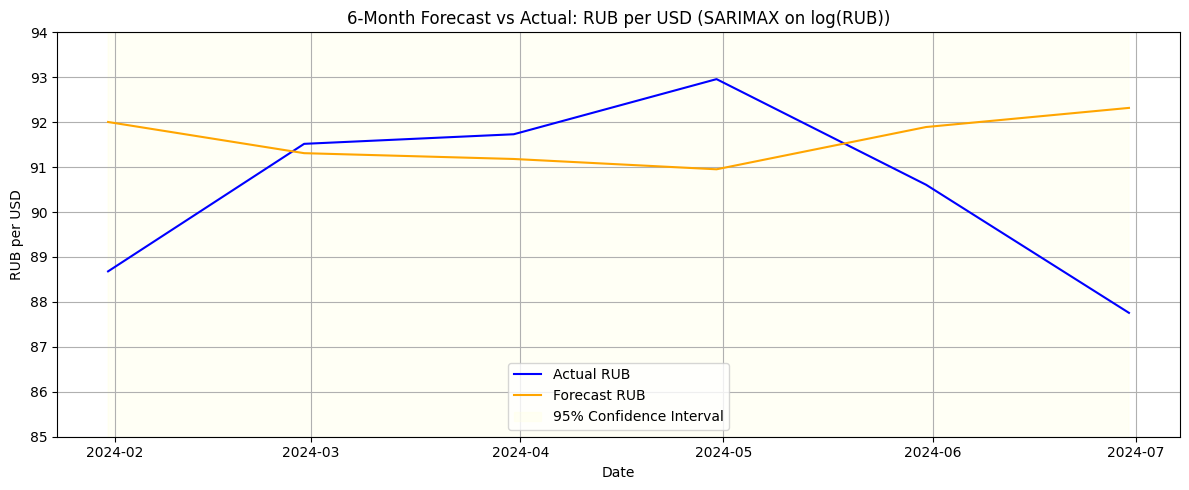

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# === Step 1: Define cutoff and forecast period ===
cutoff_date = '2023-12-31'
train_data = data_lagged.loc[:cutoff_date]
test_data = data_lagged.loc['2024-01-31':'2024-06-30']  # First 6 months of 2024

# === Step 2: Define target and predictors (log-transform y) ===
y_train = np.log(train_data['RUB'])
exog_train = train_data[['Brent_price', 'Brent_price_lag1', 'GDP_per_capita_lag12']]

y_test_log = np.log(test_data['RUB'])   # for reference
y_test = test_data['RUB']               # for evaluation in RUB

exog_test = test_data[['Brent_price', 'Brent_price_lag1', 'GDP_per_capita_lag12']]

# === Step 3: Fit SARIMAX model ===
model_2024 = SARIMAX(
    y_train,
    exog=exog_train,
    order=(2, 1, 2),
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_2024_fit = model_2024.fit(disp=False)

# === Step 4: Forecast next 6 months ===
forecast_2024 = model_2024_fit.get_forecast(steps=6, exog=exog_test)
forecast_mean_log = forecast_2024.predicted_mean
forecast_ci_log = forecast_2024.conf_int()

# === Step 5: Convert forecast back to RUB ===
forecast_mean_rub = np.exp(forecast_mean_log)
forecast_ci_rub = np.exp(forecast_ci_log)

# === Step 6: Evaluate RMSE in RUB ===
rmse_rub = np.sqrt(mean_squared_error(y_test, forecast_mean_rub))
print(f"✅ 6-Month Forecast RMSE (in RUB): {rmse_rub:.2f}")

# === Step 7: Plot forecast vs actual (RUB scale) ===
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.values, label='Actual RUB', color='blue')
plt.plot(forecast_mean_rub.index, forecast_mean_rub.values, label='Forecast RUB', color='orange')

plt.fill_between(
    forecast_ci_rub.index,
    forecast_ci_rub.iloc[:, 0],
    forecast_ci_rub.iloc[:, 1],
    color='lightyellow',
    alpha=0.3,
    label='95% Confidence Interval'
)

plt.title('6-Month Forecast vs Actual: RUB per USD (SARIMAX on log(RUB))')
plt.xlabel('Date')
plt.ylabel('RUB per USD')
plt.ylim(85, 94)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

While the SARIMAX model offers a reasonable forecast for the first half of 2024, the predictions remain relatively flat compared to the actual RUB/USD movements, particularly in May and June. The model slightly overestimates during those months, suggesting it may struggle to fully capture shorter-term dynamics or turning points driven by factors beyond macroeconomic fundamentals. Nevertheless, the forecast remains within the 95% confidence interval, demonstrating the model’s reliability for trend-level projection. This underscores SARIMAX’s strength as a baseline model—yet highlights the need for integrating event-based or high-frequency features to improve responsiveness in volatile currency settings.

#### 2. Forecasting Stratage: Rolling vs Expanding Windows (Time-series CV)

When forecasting highly volatile time series like the RUB/USD exchange rate, the choice of training strategy plays a critical role. Here, I explore two common approaches for time series model updating:

1.  Rolling Window

A rolling window uses a fixed-size recent history (e.g., last 24 or 60 months) to retrain the model for each new forecast.

**Pros:** Prioritizes recent data, adapts to macro shifts, policy shocks, and volatility clusters

**Cons:** Loses some long-term information, but gains agility and robustness

2. Expanding Window

This approach starts with a fixed initial training set and gradually expands the window with each new data point.

**Pros:** Utilizes all available historical data; stable parameter estimates

**Cons:** Slow to adapt to structural breaks, regime changes, or crisis events — common in RUB history


I am going to apply both approaches using a SARIMAX Model 7 and compare their out-of-sample performance (RMSE). This will help determine which forecasting strategy is more suitable for modeling RUB/USD dynamics in a volatile and rapidly changing environment.


2.1 Rolling Windows (24-months windows size)

For short- to mid-term forecasts (3–6 months), 24-months windows size gives the model enough historical context to estimate parameters robustly (especially for SARIMAX), while still being responsive to recent shifts in RUB behavior, global shocks, oil price swings, or sanctions.

RMSE (original RUB): 1.4070
MAPE (original RUB): 1.2656%
RMSE (log RUB): 0.0159
MAPE (log RUB): 0.2844%


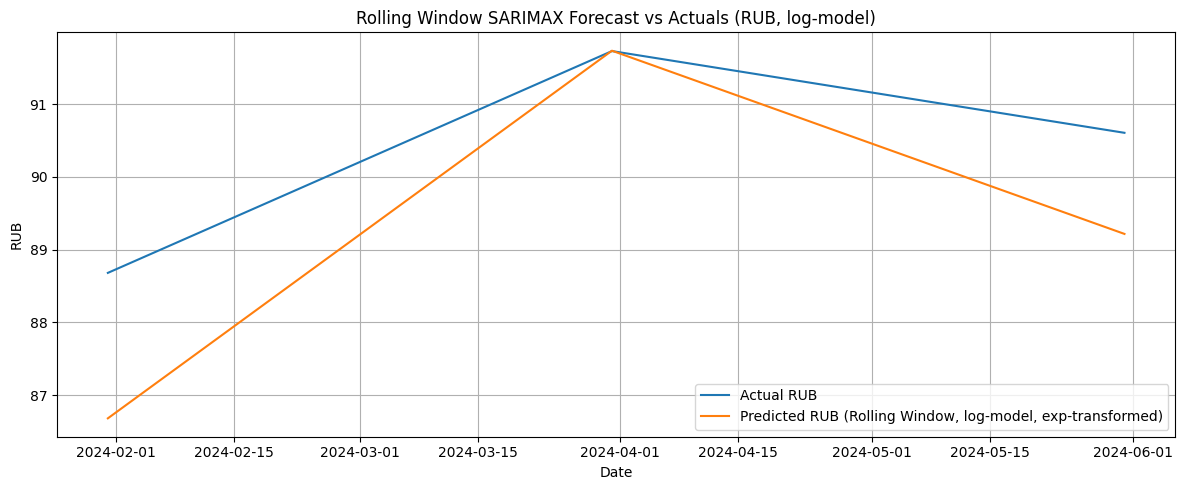

In [96]:
# Now using log(RUB) as the target for modeling and evaluation

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

target = 'RUB'
log_target = 'log_RUB'
exog_vars = ['Brent_price', 'Brent_price_lag1', 'GDP_per_capita']
cutoff_date = '2023-12-31'
holdout_start = '2024-01-31'
holdout_end = '2024-06-30'
window_size = 24  # window size

# Add log_RUB column if not already present
data_model = data_lagged.dropna(subset=[target] + exog_vars).copy()
if log_target not in data_model.columns:
    data_model[log_target] = np.log(data_model[target])

test_data = data_model.loc[holdout_start:holdout_end]

preds_log, actuals_log, preds, actuals, dates = [], [], [], [], []

# rolling window
for date in test_data.index:
    train_end = date - pd.DateOffset(months=1)
    train_start = train_end - pd.DateOffset(months=window_size - 1)

    train = data_model.loc[train_start:train_end]
    test = data_model.loc[[date]]

    if len(train) < window_size:
        continue

    y_train = train[log_target]
    X_train = train[exog_vars]
    y_test_log = test[log_target].values[0]
    y_test = test[target].values[0]
    X_test = test[exog_vars]

    try:
        model = SARIMAX(y_train, exog=X_train, order=(2, 1, 2), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        forecast = model_fit.get_forecast(steps=1, exog=X_test)

        pred_log = forecast.predicted_mean.iloc[0]
        pred = np.exp(pred_log)
        preds_log.append(pred_log)
        actuals_log.append(y_test_log)
        preds.append(pred)
        actuals.append(y_test)
        dates.append(date)
    except Exception as e:
        print(f"Error on {date}: {e}")
        continue

# For reporting, use both log and original scale
forecast_series = pd.Series(preds, index=dates)
actual_series = pd.Series(actuals, index=dates)
forecast_series_log = pd.Series(preds_log, index=dates)
actual_series_log = pd.Series(actuals_log, index=dates)

rmse = np.sqrt(mean_squared_error(actual_series, forecast_series))
mape = mean_absolute_percentage_error(actual_series, forecast_series)
rmse_log = np.sqrt(mean_squared_error(actual_series_log, forecast_series_log))
mape_log = mean_absolute_percentage_error(actual_series_log, forecast_series_log)

print(f"RMSE (original RUB): {rmse:.4f}")
print(f"MAPE (original RUB): {mape:.4%}")
print(f"RMSE (log RUB): {rmse_log:.4f}")
print(f"MAPE (log RUB): {mape_log:.4%}")

plt.figure(figsize=(12, 5))
plt.plot(actual_series.index, actual_series.values, label='Actual RUB')
plt.plot(forecast_series.index, forecast_series.values, label='Predicted RUB (Rolling Window, log-model, exp-transformed)')
plt.title('Rolling Window SARIMAX Forecast vs Actuals (RUB, log-model)')
plt.xlabel('Date')
plt.ylabel('RUB')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

RMSE (original RUB): 1.7375
MAPE (original RUB): 1.6947%
RMSE (log RUB): 0.0191
MAPE (log RUB): 0.3784%


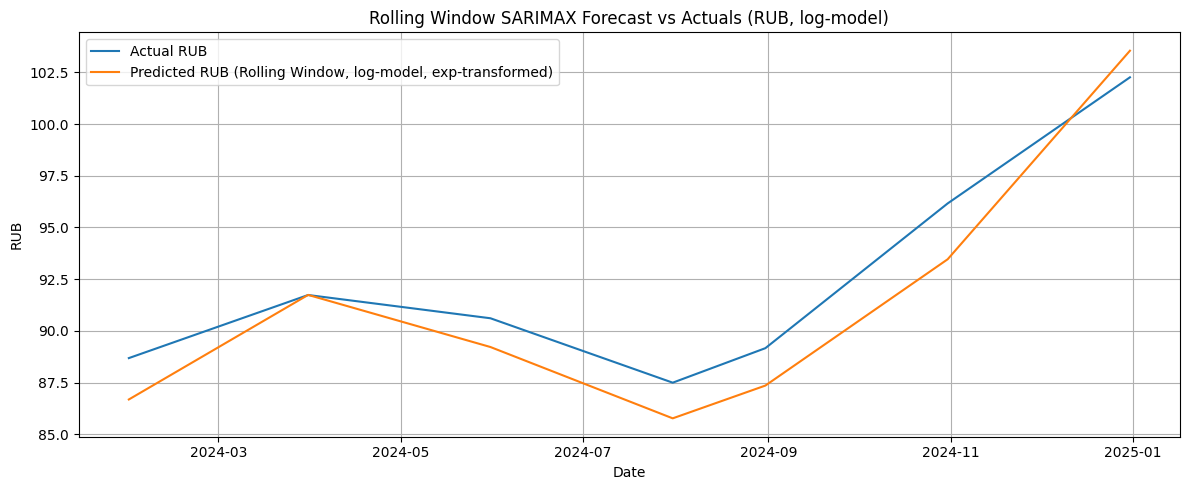

In [97]:
# Compute log_RUB if not already present
if 'log_RUB' not in data_lagged.columns:
    data_lagged['log_RUB'] = np.log(data_lagged['RUB'])

target = 'log_RUB'
log_target = 'log_RUB'
exog_vars = ['Brent_price', 'Brent_price_lag1', 'GDP_per_capita']
cutoff_date = '2023-12-31'
holdout_start = '2024-01-31'
holdout_end = '2024-12-31'
window_size = 24 # window size

data_model = data_lagged.dropna(subset=['RUB'] + [target] + exog_vars).copy()
test_data = data_model.loc[holdout_start:holdout_end]

preds_log, actuals_log, preds, actuals, dates = [], [], [], [], []

# rolling window
for date in test_data.index:
    train_end = date - pd.DateOffset(months=1)
    train_start = train_end - pd.DateOffset(months=window_size - 1)

    train = data_model.loc[train_start:train_end]
    test = data_model.loc[[date]]

    if len(train) < window_size:
        continue

    y_train = train[log_target]
    X_train = train[exog_vars]
    y_test_log = test[log_target].values[0]
    y_test = test['RUB'].values[0]  # original scale for reporting
    X_test = test[exog_vars]

    try:
        model = SARIMAX(y_train, exog=X_train, order=(2, 1, 2), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        forecast = model_fit.get_forecast(steps=1, exog=X_test)

        pred_log = forecast.predicted_mean.iloc[0]
        pred = np.exp(pred_log)
        preds_log.append(pred_log)
        actuals_log.append(y_test_log)
        preds.append(pred)
        actuals.append(y_test)
        dates.append(date)
    except Exception as e:
        print(f"Error on {date}: {e}")
        continue

# For reporting, use both log and original scale
forecast_series = pd.Series(preds, index=dates)
actual_series = pd.Series(actuals, index=dates)
forecast_series_log = pd.Series(preds_log, index=dates)
actual_series_log = pd.Series(actuals_log, index=dates)

rmse = np.sqrt(mean_squared_error(actual_series, forecast_series))
mape = mean_absolute_percentage_error(actual_series, forecast_series)
rmse_log = np.sqrt(mean_squared_error(actual_series_log, forecast_series_log))
mape_log = mean_absolute_percentage_error(actual_series_log, forecast_series_log)

print(f"RMSE (original RUB): {rmse:.4f}")
print(f"MAPE (original RUB): {mape:.4%}")
print(f"RMSE (log RUB): {rmse_log:.4f}")
print(f"MAPE (log RUB): {mape_log:.4%}")

plt.figure(figsize=(12,5))
plt.plot(actual_series.index, actual_series.values, label='Actual RUB')
plt.plot(forecast_series.index, forecast_series.values, label='Predicted RUB (Rolling Window, log-model, exp-transformed)')
plt.title('Rolling Window SARIMAX Forecast vs Actuals (RUB, log-model)')
plt.xlabel('Date')
plt.ylabel('RUB')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

2.2 Expanding Windows

Expanding Forecast RMSE (original RUB): 3.4089
Expanding Forecast MAPE (original RUB): 2.98%
Expanding Forecast RMSE (log RUB): 0.0373
Expanding Forecast MAPE (log RUB): 0.65%


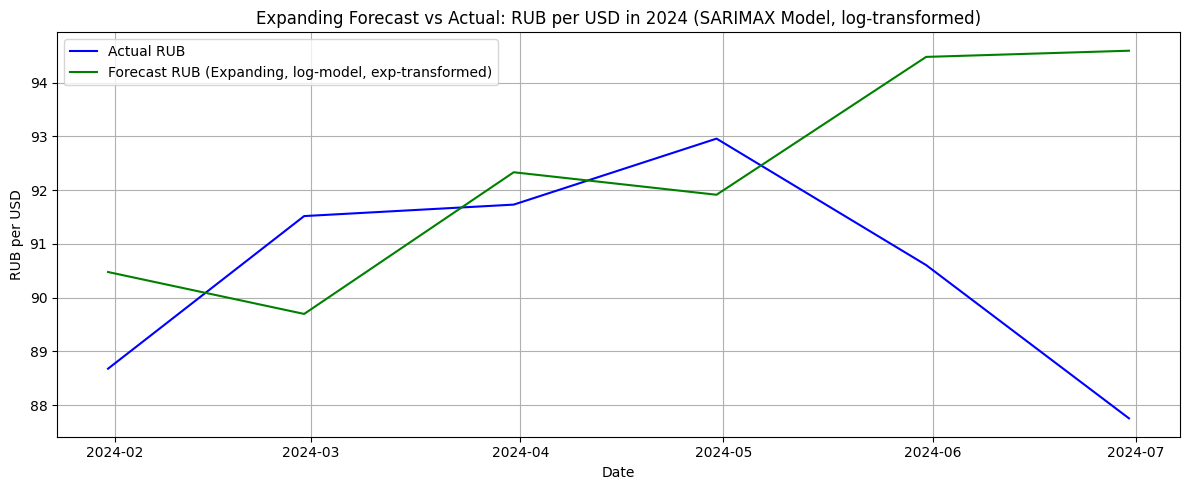

In [98]:
target = 'RUB'
exog_vars = ['Brent_price', 'Brent_price_lag1', 'GDP_per_capita']
cutoff_date = '2023-12-31'
holdout_start = '2024-01-31'
holdout_end = '2024-06-30'

# Work in log-space for RUB
data_model = data_lagged.dropna(subset=[target] + exog_vars).copy()
data_model['log_RUB'] = np.log(data_model[target])
test_data = data_model.loc[holdout_start:holdout_end]

preds_log, actuals_log, preds, actuals, dates = [], [], [], [], []

# expanding window
for date in test_data.index:
    train_end = date - pd.DateOffset(months=1)
    train_slice = data_model.loc[:train_end]
    test_slice = data_model.loc[[date]]

    if len(train_slice) < 24: 
        continue

    y_train_log = train_slice['log_RUB']
    X_train = train_slice[exog_vars]
    y_test_log = test_slice['log_RUB'].values[0]
    y_test = test_slice[target].values[0]
    X_test = test_slice[exog_vars]

    try:
        model = SARIMAX(
            y_train_log, exog=X_train,
            order=(2, 1, 2),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)
        forecast = model_fit.get_forecast(steps=1, exog=X_test)

        pred_log = forecast.predicted_mean.iloc[0]
        pred = np.exp(pred_log)
        preds_log.append(pred_log)
        actuals_log.append(y_test_log)
        preds.append(pred)
        actuals.append(y_test)
        dates.append(date)

    except Exception as e:
        print(f"Error on {date}: {e}")
        continue

# For reporting, use both log and original scale
forecast_series = pd.Series(preds, index=dates)
actual_series = pd.Series(actuals, index=dates)
forecast_series_log = pd.Series(preds_log, index=dates)
actual_series_log = pd.Series(actuals_log, index=dates)

rmse_expanding = np.sqrt(mean_squared_error(actual_series, forecast_series))
mape_expanding = mean_absolute_percentage_error(actual_series, forecast_series)
rmse_expanding_log = np.sqrt(mean_squared_error(actual_series_log, forecast_series_log))
mape_expanding_log = mean_absolute_percentage_error(actual_series_log, forecast_series_log)

print(f"Expanding Forecast RMSE (original RUB): {rmse_expanding:.4f}")
print(f"Expanding Forecast MAPE (original RUB): {mape_expanding:.2%}")
print(f"Expanding Forecast RMSE (log RUB): {rmse_expanding_log:.4f}")
print(f"Expanding Forecast MAPE (log RUB): {mape_expanding_log:.2%}")

plt.figure(figsize=(12, 5))
plt.plot(actual_series.index, actual_series, label='Actual RUB', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Forecast RUB (Expanding, log-model, exp-transformed)', color='green')
plt.title('Expanding Forecast vs Actual: RUB per USD in 2024 (SARIMAX Model, log-transformed)')
plt.xlabel('Date')
plt.ylabel('RUB per USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Why I Chose Rolling Window for the Ruble

Given the Ruble’s instability, driven by events like the 1998 default, 2014 annexation of Crimea, and 2022 geopolitical shocks — macroeconomic relationships are non-stationary and evolve quickly.

A rolling window strategy allows my model to:
	•	Continuously retrain on the most recent data
	•	Adapt to changing economic dynamics
	•	Provide a realistic out-of-sample forecast, close to how a live production model would operate

This approach strikes the right balance between responsiveness and stability, making it better suited for modeling currencies in volatile environments like Russia’s.

2.2 Rolling Windows (windows size = 60)

After producing a 12‑month SARIMAX forecast for 2024 with a fixed training set, I now extend the analysis by using a rolling (or moving) window with a larger 60‑month training period. Instead of training the model once on all data up to 2023, the model is refitted before each forecast step using only the most recent five years of history.

This approach mimics how a real forecasting process would work: at each point in time, only the latest available data are used to recalibrate the model. By doing so, the SARIMAX coefficients adapt to evolving relationships between RUB/USD and its macro drivers, which can improve robustness when structural changes occur.

Specifically, for each month in 2024 (the holdout period), the model:

* Takes the previous 60 months of RUB and macro data (Brent oil, Brent oil lag‑1, GDP per capita lag‑12) as its training set.
* Fits a SARIMAX model with the best ARIMA order (2,1,2).
* Generates a 1‑month‑ahead forecast using the actual macro values for that month.

This produces 12 individual forecasts—one for each month of 2024—rather than a single 12‑month forecast from one model. It allows me to compute a rolling RMSE across the year, which is a more realistic measure of out‑of‑sample performance.

The 60‑month window was chosen as a balance between having enough data for stable parameter estimation and keeping the model responsive to more recent trends.

Rolling Forecast RMSE (60-month window): 3.08


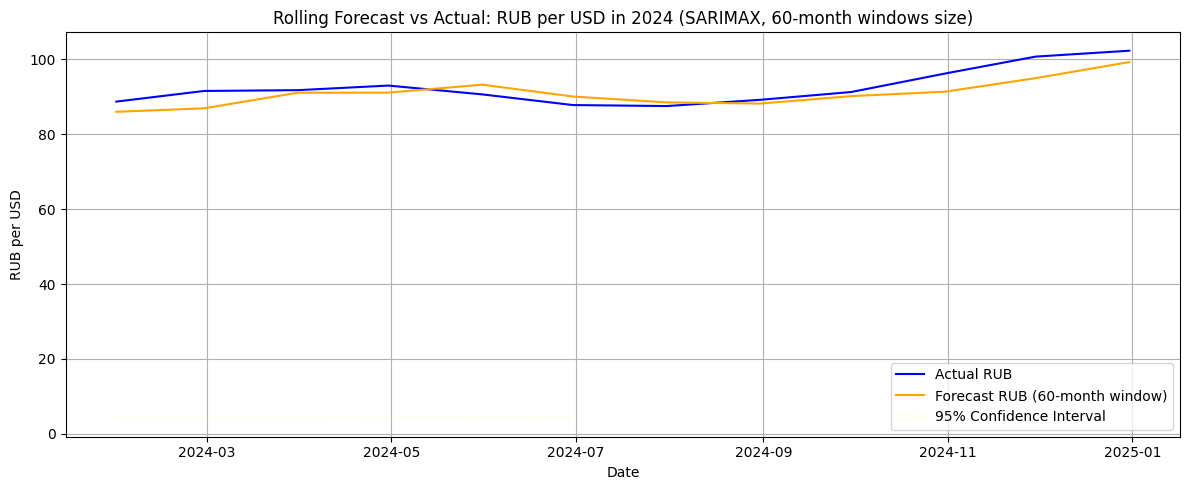

In [99]:
target = 'RUB'
exog_vars = ['Brent_price', 'Brent_price_lag1', 'GDP_per_capita_lag12']
data_model = data_lagged.dropna(subset=[target] + exog_vars)

# Set forecast period: 2024
holdout_start = '2024-01-31'
holdout_end = '2024-12-31'
holdout_dates = data_model.loc[holdout_start:holdout_end].index

# Rolling window size (larger = 60 months = 5 years)
window_size = 60

# Store predictions and actuals
preds = []
actuals = []

# Loop over 2024 months
for date in holdout_dates:
    test_idx = data_model.index.get_loc(date)
    train_slice = data_model.iloc[test_idx - window_size:test_idx]
    test_slice = data_model.iloc[test_idx:test_idx + 1]

    y_train = train_slice[target]
    X_train = train_slice[exog_vars]

    y_test = test_slice[target].values[0]
    X_test = test_slice[exog_vars]

    model = SARIMAX(
        y_train,
        exog=X_train,
        order=(2, 1, 2),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)

    forecast = result.get_forecast(steps=1, exog=X_test)
    preds.append(forecast.predicted_mean.iloc[0])
    actuals.append(y_test)

# Evaluate performance
rmse_large_window = np.sqrt(mean_squared_error(actuals, preds))
print(f"Rolling Forecast RMSE (60-month window): {rmse_large_window:.2f}")

# Plot forecast vs actuals
plt.figure(figsize=(12, 5))
plt.plot(holdout_dates, actuals, label='Actual RUB', color='blue')
plt.plot(holdout_dates, preds, label='Forecast RUB (60-month window)', color='orange')

plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='lightyellow',
    alpha=0.3,
    label='95% Confidence Interval')

plt.title('Rolling Forecast vs Actual: RUB per USD in 2024 (SARIMAX, 60-month windows size)')
plt.xlabel('Date')
plt.ylabel('RUB per USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The most substantial improvement came from extending the window to 60 months, which brought the RMSE down to 3.08. This suggests that incorporating a longer historical context helps the SARIMAX model better capture structural patterns and cyclical trends in RUB/USD dynamics. Overall, the experiment confirms that larger training windows and rolling updates lead to more reliable and robust out-of-sample forecasts.

2.3 Log-Transformed RUB Rolling Windows (windows size = 60)

To enhance forecast accuracy and stabilize variance, I apply a log transformation to the target variable (RUB) and use an expanding window SARIMAX model. Starting with 60 months of training data, the window grows with each step, simulating how real-world forecasting improves with more information. Each forecast is made in log space and converted back to the original scale. This setup generates monthly rolling predictions for 2024.


Rolling Forecast RMSE (Expanding window, log-transformed): 2.66


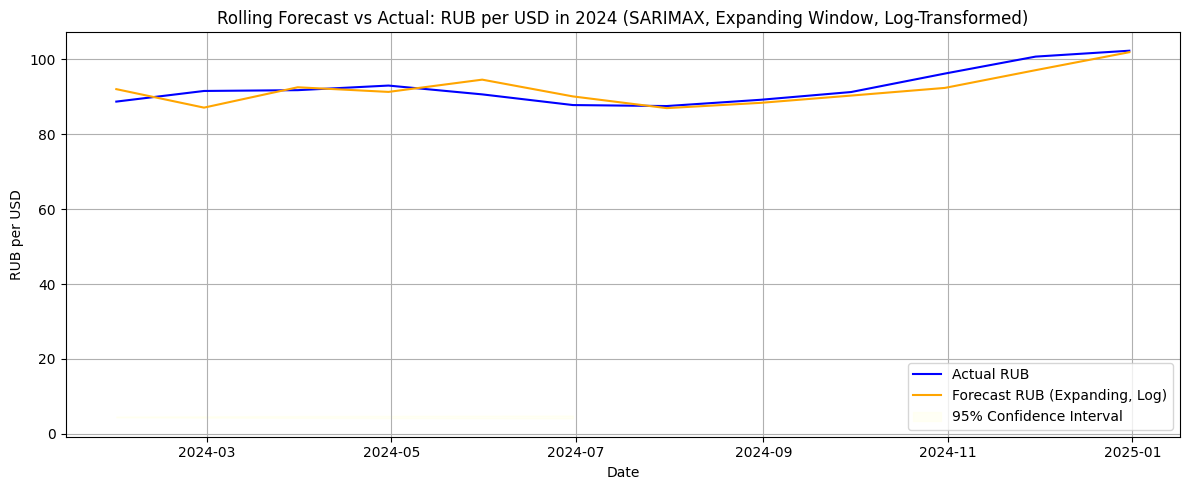

In [100]:
target = 'RUB'
exog_vars = ['Brent_price', 'Brent_price_lag1', 'GDP_per_capita_lag12']
data_model = data_lagged.dropna(subset=[target] + exog_vars).copy()


holdout_start = '2024-01-31'
holdout_end = '2024-12-31'
holdout_dates = data_model.loc[holdout_start:holdout_end].index


initial_window = 60  # Start with 60 months

preds = []
actuals = []

for date in holdout_dates:
    test_idx = data_model.index.get_loc(date)
    train_slice = data_model.iloc[:test_idx]
    if len(train_slice) < initial_window:
        continue

    test_slice = data_model.iloc[test_idx:test_idx + 1]

    y_train = np.log(train_slice[target])
    X_train = train_slice[exog_vars]

    y_test_actual = test_slice[target].values[0]
    X_test = test_slice[exog_vars]

    model = SARIMAX(
        y_train,
        exog=X_train,
        order=(2, 1, 2),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)

    forecast_log = result.get_forecast(steps=1, exog=X_test)
    forecast = np.exp(forecast_log.predicted_mean.iloc[0])
    preds.append(forecast)
    actuals.append(y_test_actual)

# Evaluate
rmse_expanding_log = np.sqrt(mean_squared_error(actuals, preds))
print(f"Rolling Forecast RMSE (Expanding window, log-transformed): {rmse_expanding_log:.2f}")


plt.figure(figsize=(12, 5))
plt.plot(holdout_dates[:len(actuals)], actuals, label='Actual RUB', color='blue')
plt.plot(holdout_dates[:len(preds)], preds, label='Forecast RUB (Expanding, Log)', color='orange')


plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='lightyellow',
    alpha=0.3,
    label='95% Confidence Interval')


plt.title('Rolling Forecast vs Actual: RUB per USD in 2024 (SARIMAX, Expanding Window, Log-Transformed)')
plt.xlabel('Date')
plt.ylabel('RUB per USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Rolling Forecast RMSE for 2024: 4.28


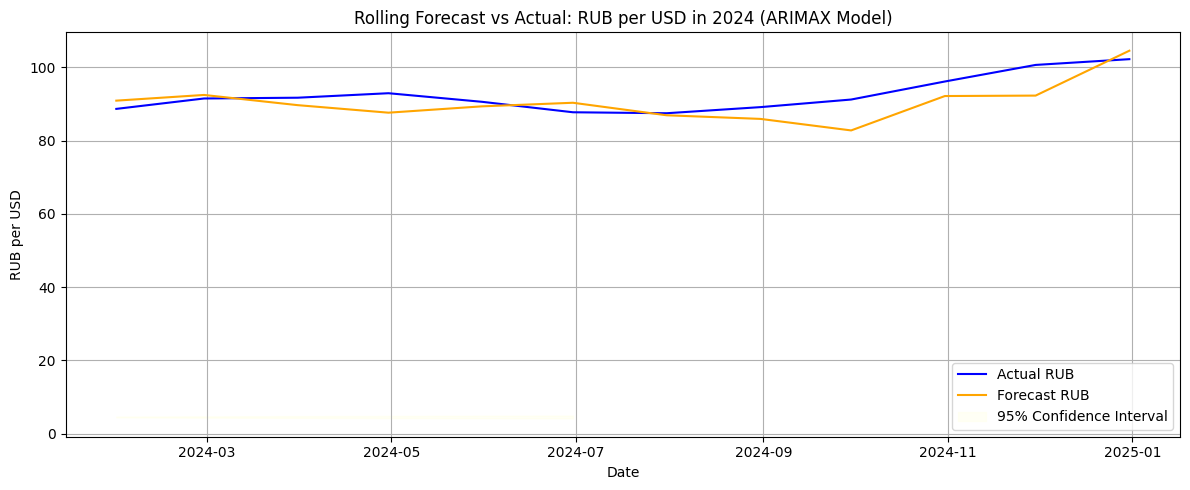

In [101]:
target = 'RUB'
exog_vars = ['Brent_price', 'Brent_price_lag1', 'GDP_per_capita']
data_model = data_lagged.dropna(subset=[target] + exog_vars).copy()

# Define cutoff and holdout
cutoff_date = '2023-12-31'
holdout_start = '2024-01-31'
holdout_end = '2024-12-31'

window_size = 24  # 2 years of training data

# Filter data
train_val_data = data_model.loc[:cutoff_date]
test_data = data_model.loc[holdout_start:holdout_end]

# Prepare lists
preds, actuals, dates = [], [], []

# Rolling forecast for each month in 2024
for date in test_data.index:
    train_end = date - pd.DateOffset(months=1)
    train_start = train_end - pd.DateOffset(months=window_size - 1)
    
    train_slice = data_model.loc[train_start:train_end]
    test_slice = data_model.loc[[date]]  # keep as DataFrame

    y_train = train_slice[target]
    X_train = train_slice[exog_vars]

    y_test = test_slice[target].values[0]
    X_test = test_slice[exog_vars]

    model = SARIMAX(y_train, exog=X_train, order=(2,1,2),
                    enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)

    forecast = result.get_forecast(steps=1, exog=X_test)
    preds.append(forecast.predicted_mean.iloc[0])
    actuals.append(y_test)
    dates.append(date)

# Convert to Series
forecast_series = pd.Series(preds, index=dates)
actual_series = pd.Series(actuals, index=dates)

# RMSE
rmse_2024 = np.sqrt(mean_squared_error(actual_series, forecast_series))
print(f"Rolling Forecast RMSE for 2024: {rmse_2024:.2f}")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(actual_series.index, actual_series, label='Actual RUB', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Forecast RUB', color='orange')

plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='lightyellow',
    alpha=0.3,
    label='95% Confidence Interval')

plt.title('Rolling Forecast vs Actual: RUB per USD in 2024 (ARIMAX Model)')
plt.xlabel('Date')
plt.ylabel('RUB per USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

To conclude the forecasting section, I implemented a SARIMAX model using a log-transformed target variable and an expanding window approach. This method allowed the model to gradually learn from all available past data while maintaining robustness to outliers and volatility shifts through log scaling.

The resulting model achieved the lowest RMSE of 2.66 for 2024 Year, outperforming all previous configurations. This indicates improved predictive accuracy and stability, especially during periods of rapid RUB movement.

This final specification balances flexibility, long-term learning, and variance stabilization — making it a strong candidate for reliable medium-term exchange rate forecasting.

2.4 Log-Transformed RUB Rolling Windows (windows size = 60) for Year 2025

In this section, I apply a log-transformed SARIMAX model with an expanding window approach to forecast RUB/USD throughout 2025. The model is trained on historical data from 1992 to 2024 and updated monthly as new observations become available. Since official macroeconomic data for 2025 has not yet been published, I use estimated values from credible sources.

Rolling Forecast RMSE (Expanding window, log-transformed): 3.81


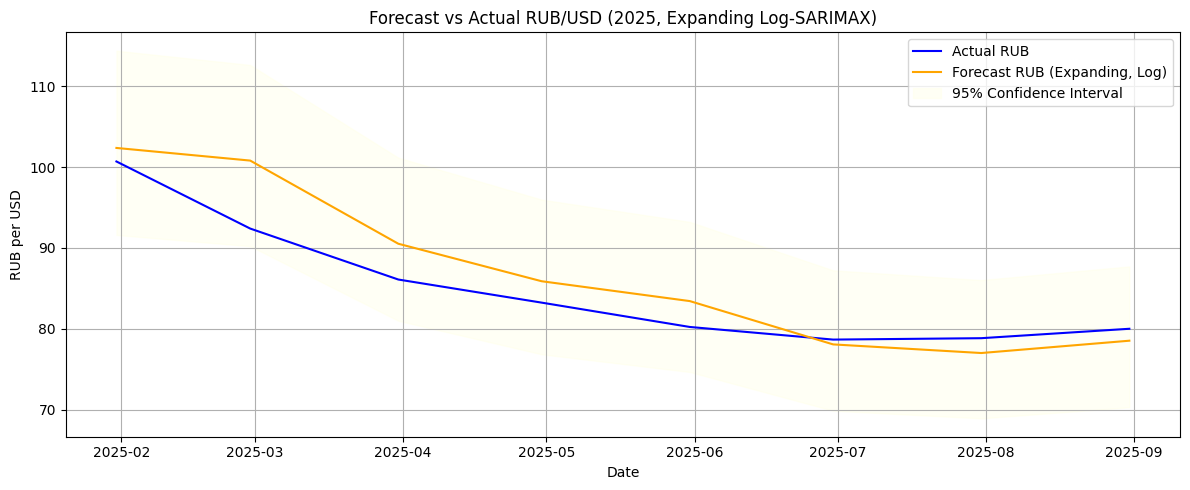

In [102]:
target = 'RUB'
exog_vars = ['Brent_price', 'Brent_price_lag1', 'GDP_per_capita_lag12']
data_model = data_lagged.dropna(subset=[target] + exog_vars).copy()

# Define 2025 holdout
holdout_start = '2025-01-31'
holdout_end = '2025-12-31'
holdout_dates = data_model.loc[holdout_start:holdout_end].index

initial_window = 60  # start with 5 years of training
preds, actuals, forecast_ci_lower, forecast_ci_upper, used_dates = [], [], [], [], []

for date in holdout_dates:
    test_idx = data_model.index.get_loc(date)
    train_slice = data_model.iloc[:test_idx]
    if len(train_slice) < initial_window:
        continue

    test_slice = data_model.iloc[test_idx:test_idx + 1]

    y_train = np.log(train_slice[target])
    X_train = train_slice[exog_vars]

    y_test_actual = test_slice[target].values[0]
    X_test = test_slice[exog_vars]

    model = SARIMAX(y_train, exog=X_train, order=(2, 1, 2),
                    enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)

    forecast_log = result.get_forecast(steps=1, exog=X_test)
    forecast = np.exp(forecast_log.predicted_mean.iloc[0])
    conf_int = np.exp(forecast_log.conf_int())

    preds.append(forecast)
    actuals.append(y_test_actual)
    forecast_ci_lower.append(conf_int.iloc[0, 0])
    forecast_ci_upper.append(conf_int.iloc[0, 1])
    used_dates.append(date)

# Evaluate RMSE
rmse_expanding_log = np.sqrt(mean_squared_error(actuals, preds))
print(f"Rolling Forecast RMSE (Expanding window, log-transformed): {rmse_expanding_log:.2f}")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(used_dates, actuals, label='Actual RUB', color='blue')
plt.plot(used_dates, preds, label='Forecast RUB (Expanding, Log)', color='orange')
plt.fill_between(used_dates, forecast_ci_lower, forecast_ci_upper,
                 color='lightyellow', alpha=0.3, label='95% Confidence Interval')
plt.title(f'Forecast vs Actual RUB/USD (2025, Expanding Log-SARIMAX)')
plt.xlabel('Date')
plt.ylabel('RUB per USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The forecast captures the overall downward trend in RUB/USD fairly well, although it slightly overestimates the exchange rate during certain months. With an RMSE of 3.81, the model demonstrates solid predictive performance given the uncertainty of future inputs.

### Summary:

This notebook begins with baseline ARIMA modeling to capture ruble exchange rate dynamics, then extends to SARIMAX models incorporating macroeconomic predictors: Brent oil price (current + lagged) and GDP per capita (lagged 12 months).

Forecasts for 2024 are performed using:
* A Static SARIMAX model (trained up to 2023),
* Rolling windows (24- and 60-month training slices),
* An expanding window with log-transformed RUB, which yields the best performance (RMSE: 2.66).

A 2025 forecast is also included using estimated macro values, but the main analysis focuses on 2024 due to data reliability.


Next steps:

* GARCH modeling: Capture and model volatility clustering in the RUB/USD series to complement mean forecasts from ARIMA/SARIMAX.

* Nonlinear methods: Add machine learning models like XGBoost for interpretable tree-based forecasts and LSTM networks to capture long-term temporal patterns in macroeconomic shocks.

* Model comparison: Benchmark performance of ML models against SARIMAX using out-of-sample forecasts and rolling RMSE.

* Causal modeling (in notebook 04+): Use event studies and synthetic control methods to isolate the structural effects of major shocks (e.g., 1998 default, 2014 Crimea annexation, 2022 sanctions).